# Let's implement an Arima Model

In [1]:
#Importing initial required libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt

In [2]:
# read in the data
df=pd.read_csv('bitcoin_USD_close_data-2017-02-09_2018-02-09.csv', 
               index_col = 'Date', #set index column to date for visualization
               parse_dates= True) #convert dates to date object

print('Shape of data',df.shape) #examine dataframe
df.head(5)

Shape of data (366, 1)


,Price
Date,
2017-02-09,988.95
2017-02-10,993.08
2017-02-11,1010.00
2017-02-12,999.51
2017-02-13,996.86


In [3]:
df.tail()

,Price
Date,
2018-02-05,6914.26
2018-02-06,7700.39
2018-02-07,7581.80
2018-02-08,8237.24
2018-02-09,8689.84


# Step 1- Checking for stationarity
###  Visualizing (Decomposing) the data

<function matplotlib.pyplot.show(close=None, block=None)>

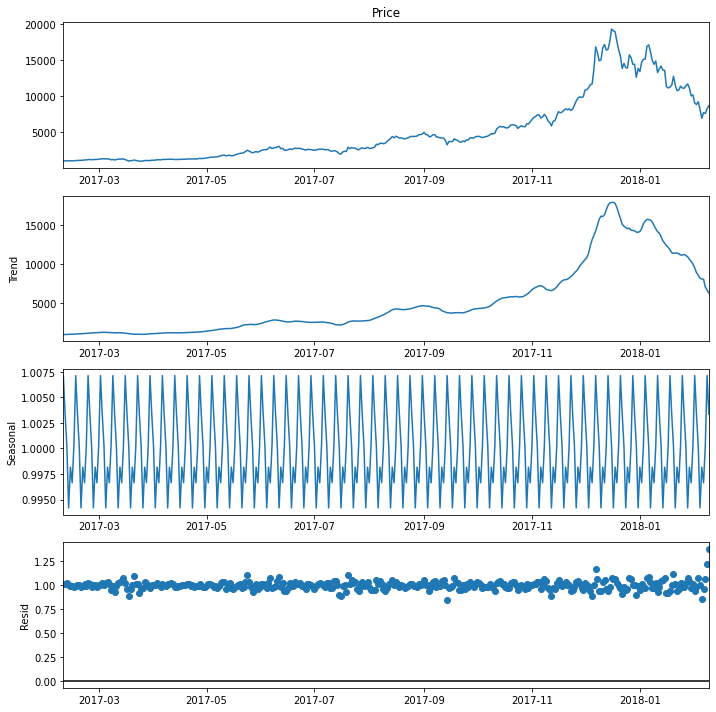

In [4]:
#import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#Assuming the series is multiplicative
decomposed = seasonal_decompose(df['Price'], 
                                model='multiplicative', 
                                extrapolate_trend='freq')

#plot decomposition
plt.rcParams["figure.figsize"] = (10,10)
decomposed.plot()
plt.show

### ADF test to ascertain stationarity.

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    if dftest[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adf_test(df['Price'])  

1. ADF :  -1.0076298495529723
2. P-Value :  0.7504713263824256
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 348
5. Critical Values :
	 1% :  -3.4492815848836296
	 5% :  -2.8698813715275406
	 10% :  -2.5712138845950587
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Making data stationary

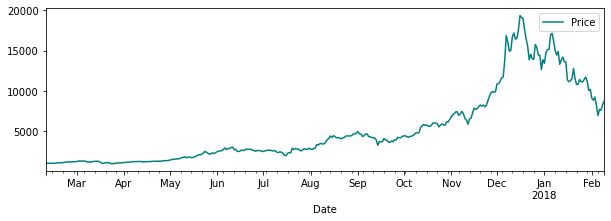

<function matplotlib.pyplot.show(close=None, block=None)>

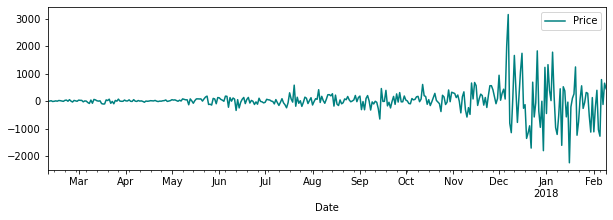

In [6]:
diff = df.diff()
# compare diff with original
df.plot(y='Price', color='teal', figsize=(10,3))
plt.show()
diff.plot(y='Price', color='teal', figsize=(10,3))
plt.show

## Checking for Seasonality

Now that we know the data is not stationary, we want to ascertain if it is seasonal

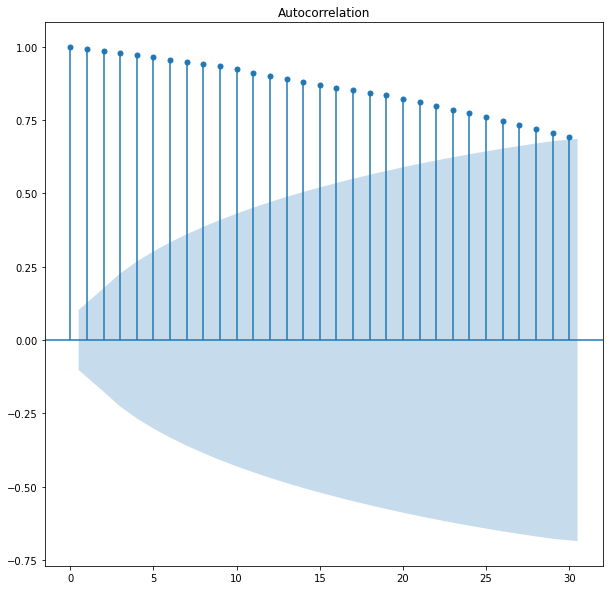

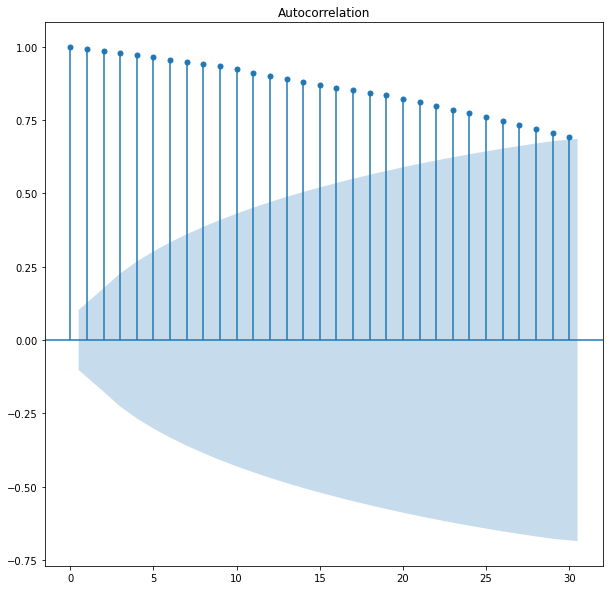

In [7]:
#plot the autocorrelation of the data
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Price'], lags = 30) 

In [8]:
df['month']=df.index.month
df['year']=df.index.year

<AxesSubplot:title={'center':'Price'}, xlabel='month'>

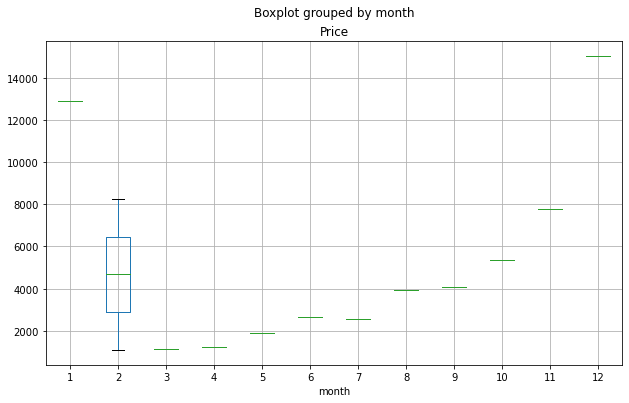

In [9]:
Monthly_Price = df.groupby(['year', 'month']).mean()
Monthly_Price.boxplot(column='Price', by='month', figsize=(10, 6))

<ipython-input-10-fc503371b44e>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  Daily_Price = df.groupby([df.index.week.rename('week'), df.index.dayofweek.rename('day')]).mean()


<AxesSubplot:title={'center':'Price'}, xlabel='day'>

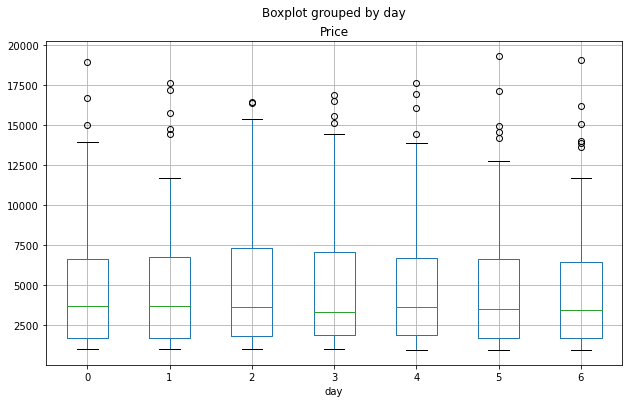

In [10]:
Daily_Price = df.groupby([df.index.week.rename('week'), df.index.dayofweek.rename('day')]).mean()
Daily_Price.boxplot(column='Price', by='day', figsize=(10, 6))

## Estimating the order of the ARIMA model

In [11]:
import pmdarima as pm

# Using the auto_arima() function
stepwise_fit = pm.auto_arima(df['Price'], trace=True,
suppress_warnings=True)

print(stepwise_fit.summary()) #best model will have the lowest AIC

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5513.262, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5519.592, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5517.319, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5516.743, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5518.353, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5511.376, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5516.966, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5509.278, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5511.335, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5517.705, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5507.929, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5515.349, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5515.934, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5510.121, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]          

## Forecasting with the model

In [12]:
# Split data for training and testing
train=df.iloc[:-60]
test=df.iloc[-60:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])


(306, 3) (60, 3)
Price    17178.1
month       12.0
year      2017.0
Name: 2017-12-12 00:00:00, dtype: float64 Price    8689.84
month       2.00
year     2018.00
Name: 2018-02-09 00:00:00, dtype: float64


In [53]:
import warnings
warnings.filterwarnings("ignore")

# Import the model module
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train['Price']]
predictions = []

# predictions are best single step to avoid overfitting and 
for t in range(len(test['Price'])):
    model = ARIMA(history, order=(1,1,1)) # initiate the model function and set parameters
    model_fit = model.fit() # fit the model
    output = model_fit.forecast() # forecast with the model
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Price'][t]
    history.append(obs)
    
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2743.825
Date:                Thu, 14 Apr 2022   AIC                           5493.650
Time:                        00:07:49   BIC                           5505.341
Sample:                             0   HQIC                          5498.296
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6891      0.063    -10.942      0.000      -0.813      -0.566
ma.L1          0.8334      0.050     16.812      0.000       0.736       0.931
sigma2      2.064e+05   6594.127     31.306      0.000    1.94e+05    2.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1463.21
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             131.72   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluating the model

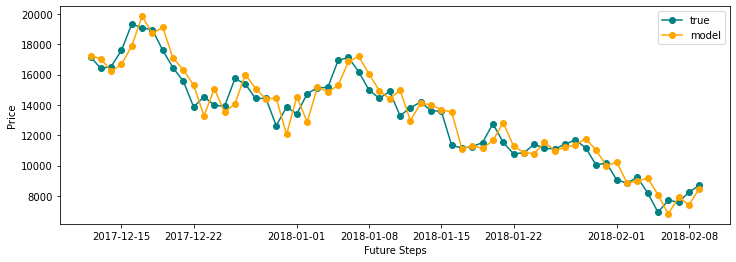

In [14]:
# plotting the model's forecasted values against the original values
test['predictions'] = predictions
plt.figure(figsize=(12, 4))
plt.plot(test['Price'], '-o', label='true', color='teal')
plt.plot(test['predictions'], '-o', label='model', color='orange')
plt.legend(fontsize=12);
plt.xlabel('Future Steps')
plt.ylabel('Price')
plt.legend()
plt.show()



In [15]:
# calculate error difference between the predictions and actual values
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(predictions,test['Price']))
print('Test Root Mean Squared Error: %.3f' % rmse)

Test Root Mean Squared Error: 934.456


# Forecasting with a seasonal ARIMA model

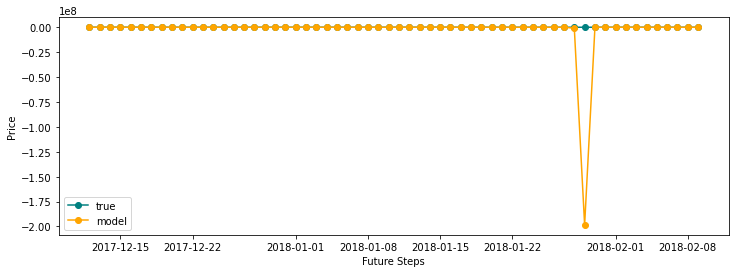

In [19]:
# Import the model module
from statsmodels.tsa.statespace.sarimax import SARIMAX
S_predictions = []

for t in range(len(test['Price'])):
    Smodel = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,7)) # initiate the model function and set parameters
    Smodel_fit = Smodel.fit() # fit the model
    S_output = Smodel_fit.forecast() # forecast with the model
    S_yhat = S_output[0]
    S_predictions.append(S_yhat)
    S_obs = test['Price'][t]
    history.append(S_obs)
    
# plotting the model's forecasted values against the original values
test['S_predictions'] = S_predictions
plt.figure(figsize=(12, 4))
plt.plot(test['Price'], '-o', label='true', color='teal')
plt.plot(test['S_predictions'], '-o', label='model', color='orange')
plt.legend(fontsize=12);
plt.xlabel('Future Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


In [17]:
# calculate error difference between the predictions and actual values
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(S_predictions,test['Price']))
print('Test Root Mean Squared Error: %.3f' % rmse)

Test Root Mean Squared Error: 25616502.727


## Model Application

In [61]:
# generate predictions
n=7
forecast = df['future_pred']
ci = model_fit.get_forecast(steps=n).conf_int(alpha=0.05 )
future_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='02/09/2018', periods=7, freq='MS'))
#pred_ci = forecast.conf_int()
ax = df[-60:].Price.plot(label='observed', figsize=(12, 6))
future_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(future_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Price')

plt.legend()
plt.show()

KeyError: 'future_pred'

In [66]:
# repeating the multi_step forecast method
history = [x for x in df['Price']]
future_pred= []
for t in range(len(test['Price'])):
    f_model = ARIMA(history, order=(1,1,1)) # initiate the model function and set parameters
    model_fit = f_model.fit() # fit the model
    future_output = model_fit.forecast() # forecast with the model
    f_yhat = future_output[0]
    future_pred.append(f_yhat)
    f_obs = test['Price'][t]
    history.append(f_obs)    
    
df['future_pred']= future_pred   


ValueError: Length of values (60) does not match length of index (366)

In [ ]:
jupyter nbconvert Bitcoin_Price_forecasting_with_Arima.ipynb --to html
jupyter nbconvert C:\Users\KENNY\771762\presentation\Bitcoin_Price_forecasting_with_Arima.ipynb --to slides --post serve
